## [Dacon] 블럭 장난감 제조 공정 최적화 경진대회  
### 나단단단단단단단단단단단단단단단단단단단 (팀명)  
### 2020년 7월 1일 (제출날짜)  

이 제출물은 대회의 유전학습 baseline 기반으로 만들어졌습니다.  

## 학습방법

1. train  
train을 위해선 처음 상태 그대로 실행하면 됩니다. 재현을 위해선 최소 370epoch의 학습이 필요합니다.  
30epoch만 학습해도 91.5점 정도의 점수를 얻을 수 있습니다.
  
  
2. inference  
이미 학습된 모델을 불러와서 학습 없이 결과를 도출하고 싶다면 
    1. 폴더 내의 model_2644.npz의 이름을 model.npz로 변경합니다.
    2. epoch를 1로 변경합니다.
    3. 전체를 실행합니다.

# 변경사항

## main 내의 변경사항
1. numpy를 통해 모델 저장 및 불러오기 기능 추가
2. 교배를 하지 않음. 대신 훨씬 많은 genome 인스턴스를 초기화해서 채점함(코어 12개 기준으로 60 -> 120, 변이 갯수는 50개로 동일)
3. 마지막 부분에서 predict를 한번 더 하지 않고 가장 성능이 높은 genome을 바로 사용
4. warnings를 제거함
5. 입력 크기가 125에서 45로 변경됨
6. 출력 크기가 4와 2로 변경됨. 4는 A라인 선택 출력, 2는 몇개를 생산할지를 결정하는 신경망의 출력에 사용됨

## module 내의 변경사항
### genome.py
1. MOL 생산 라인을 A와 B를 아예 분리함
2. process의 길이를 A라인은 98, B라인은 140으로 설정함
3. A라인은 1, 2, 4번을 생산하고 B라인은 오직 3번만을 생산함
4. 신경망과 신경망 출력을 한블럭 추가해서 A, B 라인이 다른 생산량을 갖도록함
5. 생산량은 0 혹은 max_value 둘 중 하나를 출력함
6. predict 함수 내에서 pd.loc을 반복적으로 사용하는 부분을 최대한 줄여서 좀 더 빠르게 학습함
7. warnings 제거를 위해 구현된 sigmoid 대신 scipy의 기능을 사용함
8. 입력 크기가 125에서 45로 변경됨. 수요의 길이를 줄이고 BLK의 추정량을 포함함. 또 값의 크기를 줄이고 s를 나누지않고 사용
9. 학습 도중의 genome_score 함수는 속도가 빠른 new_simulator를 사용함

### new_simulator.py
1. 원래 simulator에 비해 pd.loc을 반복적으로 사용하는 부분을 최대한 줄여서 좀 더 빠르게 학습함
2. PRT의 갯수를 계산하는 기능은 구현하지 않았기 때문에 원래 simulator를 사용함
3. 목적 함수를 부족분\*0.5+초과분\*0.2로 변경함

## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import os
from copy import deepcopy
from module.genome import Genome, genome_score

np.random.seed(34)

In [2]:
!python --version
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))

Python 3.8.1
Pandas : 1.0.4
Numpy : 1.18.1


## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [3]:
# 

## 3. 탐색적 자료분석
## Exploratory Data Analysis

In [4]:
# 

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [5]:
CPU_CORE = multiprocessing.cpu_count() # 멀티프로세싱 CPU 사용 수
N_POPULATION = 50                      # 세대당 생성수
N_BEST = 5                             # 베스트 수
N_CHILDREN = 5                         # 자손 유전자 수
PROB_MUTATION = 0.5                    # 돌연변이
REVERSE = False                       # 배열 순서 (False: ascending order, True: descending order)

score_ini = 1e8                        # 초기 점수
input_length = 45                      # 입력 데이터 길이
output_length_1 = 4                    # Event (MODULE_1~3, PROCESS)
output_length_2 = 2                    # MOL(0 or max_value)
h1 = 50                                # 히든레이어1 노드 수
h2 = 50                                # 히든레이어2 노드 수
h3 = 50                                # 히든레이어3 노드 수
EPOCHS = 370                           # 반복 횟수

genomes = []
for _ in range(N_POPULATION):
    genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
    genomes.append(genome)
    
if os.path.isfile("model.npz"):
    print("model loading")
    save_model = np.load("model.npz")
    genomes[-1].w1 = save_model["w1"]
    genomes[-1].w2 = save_model["w2"]
    genomes[-1].w3 = save_model["w3"]
    genomes[-1].w4 = save_model["w4"]
    genomes[-1].w5 = save_model["w5"]
    genomes[-1].w6 = save_model["w6"]
    genomes[-1].w7 = save_model["w7"]
    genomes[-1].w8 = save_model["w8"]
    genomes[-1].w9 = save_model["w9"]
    genomes[-1].w10 = save_model["w10"]
    genomes[-1].w11 = save_model["w11"]
    genomes[-1].w12 = save_model["w12"]    

try:
    for i in range(N_BEST):
        genomes[i] = best_genomes[i]
except:
    best_genomes = []
    for _ in range(5):
        genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
        best_genomes.append(genome)

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation
1. PRT는 마지막에 MOL을 통해 생산량 결정
2. Event A, Event B (MOL_A, MOL_B) 를 다른 값으로 출력
3. Event는 CHECK와 PROCESS 만 사용함
4. 목적 함수로 수요 부족분을 0.5, 수요 초과분을 0.2의 비율로 더한것을 고려함
5. Event와 MOL에 대해 인공신경망 모델을 만들어 유전 알고리즘으로 학습

In [6]:
n_gen = 1
score_history = []
high_score_history = []
mean_score_history = []

while n_gen <= EPOCHS:    
    genomes = np.array(genomes)    
    while len(genomes)%(CPU_CORE*10) != 0:
        genomes = np.append(genomes, Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3))
    
    #print(f"총 채점 갯수 : {len(genomes)}")
    genomes = genomes.reshape((len(genomes)//CPU_CORE, CPU_CORE))

    for idx, _genomes in enumerate(genomes):
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes=CPU_CORE)
            genomes[idx] = pool.map(genome_score, _genomes)
            pool.close()
            pool.join()    

    genomes = list(genomes.reshape(genomes.shape[0]*genomes.shape[1]))
    
     # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    # 평균 점수
    s = 0 
    for i in range(N_BEST):
        s += genomes[i].score
    s /= N_BEST
    
    # Best Score
    bs = genomes[0].score 
    
    # Best Model 추가
    if best_genomes is not None:
        genomes.extend(best_genomes)
        
    # score에 따라 정렬
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    score_history.append([n_gen, genomes[0].score])
    high_score_history.append([n_gen, bs])
    mean_score_history.append([n_gen, s])
    
    # 결과 출력
    print('EPOCH #%s\tHistory Best Score: %s\tBest Score: %s\tMean Score: %s' % (n_gen, genomes[0].score, bs, s))    
    
    # 모델 업데이트
    best_genomes = deepcopy(genomes[:N_BEST])
    
   
    # 모델 초기화
    genomes = []
    for i in range(int(N_POPULATION / len(best_genomes))):
        for bg in best_genomes:
            new_genome = deepcopy(bg)            
            mean = 0
            stddev = 0.2                        
            # 50% 확률로 모델 변형
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w1 += new_genome.w1 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w2 += new_genome.w2 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w3 += new_genome.w3 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w4 += new_genome.w4 * np.random.normal(mean, stddev, size=(h3, output_length_1)) * np.random.randint(0, 2, (h3, output_length_1))                
                
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w5 += new_genome.w5 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w6 += new_genome.w6 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w7 += new_genome.w7 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w8 += new_genome.w8 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
        
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w9 += new_genome.w9 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w10 += new_genome.w10 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w11 += new_genome.w11 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w12 += new_genome.w12 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
            genomes.append(new_genome)
    #print(f"변이 갯수 : {len(genomes)}")
            
    if REVERSE:
        if bs < score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]
    else:
        if bs > score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]  
        
    n_gen += 1

    

## 6. 결과 및 결언
## Conclusion & Discussion

EPOCH #1	History Best Score: 3378000.1	Best Score: 3378000.1	Mean Score: 4239769.66
EPOCH #2	History Best Score: 3378000.1	Best Score: 3484698.1	Mean Score: 3758416.8200000003
EPOCH #3	History Best Score: 3378000.1	Best Score: 3378000.1	Mean Score: 3456067.1399999997
EPOCH #4	History Best Score: 3215036.2	Best Score: 3215036.2	Mean Score: 3364107.3600000003
EPOCH #5	History Best Score: 3215036.2	Best Score: 3264620.0	Mean Score: 3382611.22
EPOCH #6	History Best Score: 3215036.2	Best Score: 3279944.9	Mean Score: 3391693.0599999996
EPOCH #7	History Best Score: 3168145.4	Best Score: 3168145.4	Mean Score: 3246116.9400000004
EPOCH #8	History Best Score: 3168145.4	Best Score: 3178470.9	Mean Score: 3237967.06
EPOCH #9	History Best Score: 3168145.4	Best Score: 3169600.4	Mean Score: 3243405.1399999997
EPOCH #10	History Best Score: 3168145.4	Best Score: 3175204.8000000003	Mean Score: 3366794.22
EPOCH #11	History Best Score: 3136402.7	Best Score: 3136402.7	Mean Score: 3248316.4200000004
EPOCH #12

### 결과 그래프

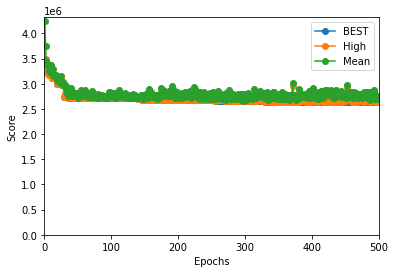

In [7]:
import matplotlib.pyplot as plt

# Score Graph
score_history = np.array(score_history)
high_score_history = np.array(high_score_history)
mean_score_history = np.array(mean_score_history)

plt.plot(score_history[:,0], score_history[:,1], '-o', label='BEST')
plt.plot(high_score_history[:,0], high_score_history[:,1], '-o', label='High')
plt.plot(mean_score_history[:,0], mean_score_history[:,1], '-o', label='Mean')
plt.legend()
plt.xlim(0, EPOCHS)
plt.ylim(bottom=0)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

### Submission 파일 만들기

In [8]:
# 재고 계산
from module.simulator import Simulator
simulator = Simulator()

submission = best_genomes[0].submission
_, df_stock = simulator.get_score(submission) 


# PRT 개수 계산
PRTs = df_stock[['PRT_1', 'PRT_2', 'PRT_3', 'PRT_4']].values
PRTs = (PRTs[:-1] - PRTs[1:])[24*23:]
PRTs = np.ceil(PRTs * 1.1)
PAD = np.zeros((24*23+1, 4))
PRTs = np.append(PRTs, PAD, axis=0).astype(int)

# Submission 파일에 PRT 입력
submission.loc[:, 'PRT_1':'PRT_4'] = PRTs
submission.to_csv('Dacon_baseline.csv', index=False)

np.savez("model", w1=best_genomes[0].w1,
                  w2=best_genomes[0].w2,
                  w3=best_genomes[0].w3,
                  w4=best_genomes[0].w4,
                  w5=best_genomes[0].w5,
                  w6=best_genomes[0].w6,
                  w7=best_genomes[0].w7,
                  w8=best_genomes[0].w8,
                  w9=best_genomes[0].w9,
                  w10=best_genomes[0].w10,
                  w11=best_genomes[0].w11,
                  w12=best_genomes[0].w12)